**Import section**

In [ ]:
import torch
import torchvision
import cv2
import glob
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import warnings
from tqdm import tqdm
from PIL import Image
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.ssd import SSDClassificationHead
from torch.optim import lr_scheduler
from torchvision.ops import nms
from collections import Counter
warnings.filterwarnings("ignore")

**1.1) So, on the first step, I will explore pretrained Faster R-CNN model from "torchvision.models.detection". Let's have a look into it's inference**

In [ ]:
# Downloading pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval();

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 224MB/s]  


In [ ]:
img = Image.open("/kaggle/input/person/person.jpg").convert("RGB")
img_np = np.array(img.resize((224, 224), resample=Image.Resampling.BILINEAR)) / 255.
img = torch.from_numpy(img_np.astype('float32')).permute(2,0,1)
img = img[None, :]

prediction = model(img)
prediction

[{'boxes': tensor([[ 80.4037,   7.8835, 172.4453, 222.5493],
          [110.5395,  81.1567, 125.0058, 143.9697],
          [ 83.7358, 141.3720, 100.0268, 177.4902],
          [155.8948,  18.7532, 211.7414, 112.2428],
          [131.7541,  47.4564, 137.5286,  69.0857],
          [130.7819,  61.2773, 136.7437,  71.9043],
          [134.0035,  47.3697, 137.7374,  64.1765],
          [142.9050,  97.0680, 176.4174, 215.1674],
          [133.1741,  47.4170, 142.1664,  70.3199],
          [167.8597,  88.0261, 204.3929, 114.8128],
          [135.0851,  59.3315, 143.1465,  69.2671],
          [149.6271, 163.9708, 180.2368, 220.3077],
          [130.3342,  50.8435, 136.1245,  71.7954],
          [129.7811,  58.0624, 138.8913,  72.4783],
          [131.4947,  60.8120, 142.5067,  71.0598],
          [111.5934,  88.5289, 150.7675, 217.9020],
          [135.3670,  46.3713, 138.9952,  65.9794],
          [141.9703,  89.4028, 151.7357, 211.4714],
          [ 81.2240, 138.8648,  98.6426, 183.0381],
   

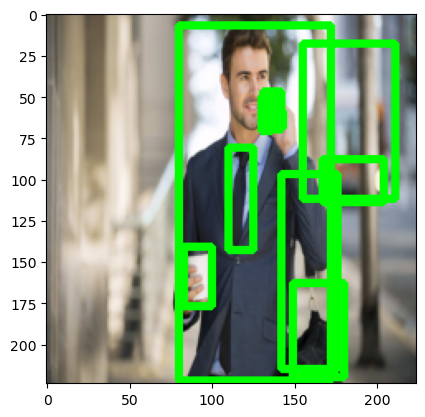

In [ ]:
# Function to plot bboxed image
def plot_image(image, prediction):
    boxes = prediction[0]["boxes"][prediction[0]["scores"] > 0.2]
    labels = prediction[0]["labels"]
    for box in boxes:
        x1, y1, x2, y2 = list(map(int, box))
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
    plt.imshow(image)

plot_image(img_np, prediction)

**1.2) On the second step i will implement dataset class, which will prepare data for model**

In [ ]:
class DataSet(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root # Root folder
        self.labels = ['bg', 'orange', 'apple', 'banana'] # All dataset's labels
        self.l2i = { label: i for i, label in enumerate(self.labels)} # Forward "Encoder"
        self.imgs = sorted([root + '/' + i for i in os.listdir(root) if i[-4:] == ".jpg"]) # Image paths
        self.xmls = sorted([root + '/' + i for i in os.listdir(root) if i[-4:] == ".xml"]) # XML paths

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_path = self.imgs[index]
        xml_path = self.xmls[index]

        # Image preprocessing
        img = Image.open(img_path).convert("RGB")
        W, H = img.size
        img = np.array(img.resize((224, 224), resample=Image.Resampling.BILINEAR)) / 255.
        img = torch.from_numpy(img.astype('float32')).permute(2,0,1) # converting np_array, H,W,C -> torch_tensor, C,H,W

        # Parsing XML file
        tree = et.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for object in root.findall('object'):
            label = object.find('name').text
            xmin = float(object.find('bndbox').find('xmin').text)
            ymin = float(object.find('bndbox').find('ymin').text)
            xmax = float(object.find('bndbox').find('xmax').text)
            ymax = float(object.find('bndbox').find('ymax').text)
            bbox = [xmin / W, ymin / H, xmax / W, ymax / H]
            bbox = (bbox * np.array([224, 224, 224, 224])).astype(np.int16).tolist()
            boxes.append(bbox)
            labels.append(label)

        # Defining "target"
        target = {}
        target['labels'] = torch.tensor([self.l2i[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()

        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

train_folder = "/kaggle/input/fruit-images-for-object-detection/train_zip/train"
test_folder = "/kaggle/input/fruit-images-for-object-detection/test_zip/test"

train_dataset = DataSet(train_folder)
train_dataloader = DataLoader(train_dataset, batch_size=8,shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)

val_dataset = DataSet(test_folder)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, collate_fn=val_dataset.collate_fn, drop_last=True)

**So, let's check correctness of our model with implemented dataset**

In [ ]:
# Tend to change the FastRCNNPredictor
in_features = model.roi_heads.box_predictor.cls_score.in_features # Check how many classes predictor has on it's input
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4) # Change the number of output - number of classes then

# Let's check the inference

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.train()
device = torch.device("cuda:0")
model = model.to(device)

batch = next(iter(train_dataloader))
images, targets = batch

images = [image.to(device) for image in images]
targets = [{labels: boxes.to(device) for labels, boxes in target.items()} for target in targets]

predictions = model(images, targets) # And we can see that it compiled without any error !
predictions

{'loss_classifier': tensor(1.0359, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1679, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0059, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)}

**So, we need to validate our model with some metrics. I've chosen the mAP. Our next step is to implement it.**

In [ ]:
# "Helper" function
def intersection_over_union(boxes_preds, boxes_labels):

    box1_x1 = boxes_preds[..., 0:1]
    box1_y1 = boxes_preds[..., 1:2]
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4]
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

# mAP function
def mAP(predictions, ground_truths, iou_threshold=0.5, num_classes=4):
    # predictions (list of lists) : [[idx_of_image, class, score, x1, y1, x2, y2], ...]
    # ground_truths (list of lists) : [[idx_of_image, class, x1, y1, x2, y2], ...]


    # Preprocessing data

    # Reformatting predictions
    reformatted_predictions = []
    for image_number, prediction in enumerate(predictions):
        boxes = prediction["boxes"].cpu().detach().tolist()
        labels = prediction["labels"].cpu().detach().tolist()
        scores = prediction["scores"].cpu().detach().tolist()
        for idx, box in enumerate(boxes):
            add = [image_number, labels[idx], scores[idx], box[0], box[1], box[2], box[3]]
            reformatted_predictions.append(add)

    # Reformatting ground_truths
    reformatted_ground_truths = []
    for image_number, ground_truth in enumerate(list(ground_truths)):
        boxes = ground_truth["boxes"].tolist()
        labels = ground_truth["labels"].tolist()

        for i in range(len(boxes)):
            reformatted_prediction = [image_number, labels[i], boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]]
            reformatted_ground_truths.append(reformatted_prediction)


    ious = np.arange(0.5, 0.95, 0.05)
    avg_precisions = []
    eps = 1e-6
    results = []

    # Code of the funcion below
    # 1) We need to group boxes with the same class
    # 2) On the first step we need to group boxes with the same image index
    for IOU in ious:
        for c in range(num_classes):
            detection_in_cur_class = []
            ground_truths_in_cur_class = []

            # Adding each one prediciton which has the 'c' class to handling ("c" in our case may be in {0,1,2,3} - num_classes)
            for prediction in reformatted_predictions:
                if prediction[1] == c:
                    detection_in_cur_class.append(prediction)
            # Adding each one gt box which has the 'c' class to handling
            for ground_truth in reformatted_ground_truths:
                if ground_truth[1] == c:
                    ground_truths_in_cur_class.append(ground_truth)

            # Dictionary, where key is an image index and value is a number of ground truth boxes there
            boxes_per_image = Counter([ground_truth[0] for ground_truth in ground_truths_in_cur_class])
            # Updating our dictionary, as we need to know if we covered some gt_boxes
            for image_idx, num_gt_boxes in boxes_per_image.items():
                boxes_per_image[image_idx] = torch.zeros(num_gt_boxes)

            # Sorting predictions over scores in descending order
            detection_in_cur_class.sort(key=lambda x: x[2], reverse=True)
            # Initializing things through which we will get AP
            TP = torch.zeros(len(detection_in_cur_class))
            FP = torch.zeros(len(detection_in_cur_class))
            Total_ground_truths = len(ground_truths_in_cur_class)


            for detection_idx, detection in enumerate(detection_in_cur_class):
                # GT boxes with the same class and image as "detection"
                ground_truths_same_image = [box for box in ground_truths_in_cur_class if box[0] == detection[0]]
                number_gts_for_particular_detection = len(ground_truths_same_image)

                max_iou = 0
                best_ground_truth_idx = 0

                for idx, ground_truth in enumerate(ground_truths_same_image):
                    iou = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(ground_truth[2:]))

                    if iou > max_iou:
                        max_iou = iou
                        best_ground_truth_idx = idx

                if max_iou > IOU:
                    if boxes_per_image[detection[0]][best_ground_truth_idx] == 0:
                        TP[detection_idx] = 1
                        boxes_per_image[detection[0]][best_ground_truth_idx] = 1
                    else:
                        FP[detection_idx] = 1
                else:
                    FP[detection_idx] = 1
            TP_cumsum = torch.cumsum(TP, dim=0)
            FP_cumsum = torch.cumsum(FP, dim=0)
            recalls = TP_cumsum / (Total_ground_truths + eps)
            precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + eps))
            precisions = torch.cat((torch.tensor([1]), precisions))
            recalls = torch.cat((torch.tensor([0]), recalls))
            avg_precisions.append(torch.trapz(precisions, recalls))
        results.append(sum(avg_precisions) / len(avg_precisions))
    return sum(results) / len(results)

**1.3) On the third step I will implement train/val loop for our model**

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=5e-4, momentum=0.9)
n_epochs = 5

l_t_history = []
l_v_history = []
mAP_history = []
best_mAP_frcnn = 0
for epoch in range(n_epochs):
    loss_train_history = 0
    loss_train_classifier = 0
    loss_train_box_reg = 0
    loss_train_objectness = 0
    loss_train_rpn_box_reg = 0

    model.train()
    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}") as pbar:
        for i, data in enumerate(pbar):
            images, targets = data
            images = [image.to(device) for image in images]
            targets = [{labels: boxes.to(device) for labels, boxes in target.items()} for target in targets]

            optimizer.zero_grad()
            losses = model(images, targets)
            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()

            loss_train_history += loss.cpu().item()
            ltc, ltbr, lto, ltrbr = [loss.cpu().item() for loss in losses.values()]
            loss_train_classifier += ltc
            loss_train_box_reg += ltbr
            loss_train_objectness += lto
            loss_train_rpn_box_reg += ltrbr

        l_t_history.append(loss_train_history)
        print(f"United training loss: {loss_train_history / len(train_dataloader)}")
        print(f"Classifier training loss: {loss_train_classifier / len(train_dataloader)}")
        print(f"Box regression training loss: {loss_train_box_reg / len(train_dataloader)}")
        print(f"Objectness training loss: {loss_train_objectness / len(train_dataloader)}")
        print(f"RPN box regression training loss: {loss_train_rpn_box_reg / len(train_dataloader)}")



    loss_val_history = 0
    loss_val_classifier = 0
    loss_val_box_reg = 0
    loss_val_objectness = 0
    loss_val_rpn_box_reg = 0

    with tqdm(val_dataloader, desc=f"Epoch {epoch+1}") as pbar:
        with torch.no_grad():
            for i, data in enumerate(pbar):
                images, targets = data
                images = [image.to(device) for image in images]
                targets = [{labels: boxes.to(device) for labels, boxes in target.items()} for target in targets]

                optimizer.zero_grad()
                losses = model(images, targets)
                loss = sum(loss for loss in losses.values())

                loss_val_history += loss.cpu().item()
                lvc, lvbr, lvo, lvrbr = [loss.cpu().item() for loss in losses.values()]
                loss_val_classifier += lvc
                loss_val_box_reg += lvbr
                loss_val_objectness += lvo
                loss_val_rpn_box_reg += lvrbr
            l_v_history.append(loss_val_history)
            print(f"United val loss: {loss_val_history / len(val_dataloader)}")
            print(f"Classifier val loss: {loss_val_classifier / len(val_dataloader)}")
            print(f"Box regression val loss: {loss_val_box_reg / len(val_dataloader)}")
            print(f"Objectness val loss: {loss_val_objectness / len(val_dataloader)}")
            print(f"RPN box regression val loss: {loss_val_rpn_box_reg / len(val_dataloader)}")


    map_per_batch = []

    model.eval()
    with tqdm(val_dataloader, desc=f"Epoch {epoch+1}") as pbar:
        with torch.no_grad():
            for i, data in enumerate(pbar):
                images, targets = data
                images = [image.to(device) for image in images]

                optimizer.zero_grad()
                predictions = model(images)
                map_this_batch = mAP(predictions, targets)
                if map_this_batch > best_mAP_frcnn:
                    best_mAP_frcnn = map_this_batch
                map_per_batch.append(map_this_batch)

    mAP_history.append(sum(map_per_batch) / len(map_per_batch))
    print(f"mAP on this epoch is: {sum(map_per_batch) / len(map_per_batch)}")
    print("Saving weights...")
    torch.save(model.state_dict(), 'model.pth') # Save our trained weights

Epoch 1: 100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


United training loss: 0.09047588557004929
Classifier training loss: 0.027059507121642432
Box regression training loss: 0.05904510580003262
Objectness training loss: 0.001637025044086234
RPN box regression training loss: 0.002734247723128647


Epoch 1: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


United val loss: 0.15867179525750025
Classifier val loss: 0.052133671806326935
Box regression val loss: 0.0977044403553009
Objectness val loss: 0.004245252531420972
RPN box regression val loss: 0.004588431711973888


Epoch 1: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


mAP on this epoch is: 0.66081303358078
Saving weights...


Epoch 2: 100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


United training loss: 0.08288760048647721
Classifier training loss: 0.024107224866747858
Box regression training loss: 0.05480757057666778
Objectness training loss: 0.0014433344011195004
RPN box regression training loss: 0.0025294705720928807


Epoch 2: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


United val loss: 0.16392324651990617
Classifier val loss: 0.056745528642620356
Box regression val loss: 0.09708639127867562
Objectness val loss: 0.005373524834534952
RPN box regression val loss: 0.004717807318749172


Epoch 2: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


mAP on this epoch is: 0.6599656939506531
Saving weights...


Epoch 3: 100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


United training loss: 0.07934421387811502
Classifier training loss: 0.02292034591858586
Box regression training loss: 0.05244697257876396
Objectness training loss: 0.0014844226350154107
RPN box regression training loss: 0.002492472263596331


Epoch 3: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


United val loss: 0.14679438195058278
Classifier val loss: 0.04760889283248356
Box regression val loss: 0.08967702090740204
Objectness val loss: 0.0044458456416448045
RPN box regression val loss: 0.005062624546033996


Epoch 3: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


mAP on this epoch is: 0.6803296208381653
Saving weights...


Epoch 4: 100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


United training loss: 0.07726172966261705
Classifier training loss: 0.022460465723027786
Box regression training loss: 0.05118355794499318
Objectness training loss: 0.0012456861528335138
RPN box regression training loss: 0.002372019460502391


Epoch 4: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


United val loss: 0.1598200329712459
Classifier val loss: 0.05462926918906825
Box regression val loss: 0.09507606018866811
Objectness val loss: 0.005493745906278491
RPN box regression val loss: 0.004620950735573258


Epoch 4: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


mAP on this epoch is: 0.6570749282836914
Saving weights...


Epoch 5: 100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


United training loss: 0.07431921797494094
Classifier training loss: 0.020729081922521195
Box regression training loss: 0.050210215896368024
Objectness training loss: 0.0012380433967337013
RPN box regression training loss: 0.0021418768679723143


Epoch 5: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


United val loss: 0.16440859117678233
Classifier val loss: 0.056725507868187766
Box regression val loss: 0.09865478905183929
Objectness val loss: 0.004439645962390516
RPN box regression val loss: 0.0045886503732098


Epoch 5: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


mAP on this epoch is: 0.6597537994384766
Saving weights...


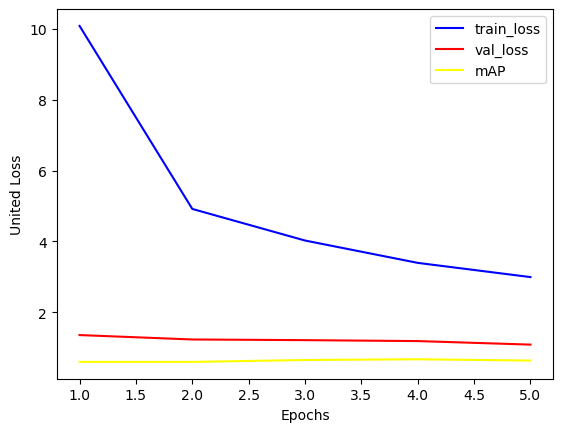

In [ ]:
# Plotting results
x = [i+1 for i in range(n_epochs)]
y1 = l_t_history
y2 = l_v_history
y3 = mAP_history

fig, ax = plt.subplots()
ax.plot(x, y1, color='blue', label='train_loss')
ax.plot(x, y2, color='red', label='val_loss')
ax.plot(x, y3, color='yellow', label='mAP')

ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('United Loss')

plt.show()

**Below we check our predictions with plotting an image of random fruit and it's bounding boxes**

In [ ]:
# Backward "Encoder"
i2l = { i: label for i, label in enumerate(['bg', 'orange', 'apple', 'banana'])}

# Let's create the fucntion which will decode out prediction + perform NMS + plotting
def decode_print(image, prediction):
    # Preprocessing prediction

    boxes = prediction[0]["boxes"].cpu().detach()
    labels = np.array([i2l[i] for i in prediction[0]['labels'].cpu().detach().numpy()])
    scores = prediction[0]["scores"].cpu().detach()

    # Computing indexes with NonMaxSupression
    indexes = nms(boxes, scores, 0.1).tolist()

    boxes = boxes.tolist()
    labels.tolist()
    scores.tolist()

    for index in indexes:
        if (scores[index] > 0.5):
            x1, y1, x2, y2 = list(map(int, boxes[index]))

            w = abs(x2 - x1)
            h = abs(y2 - y1)


            text_size, _ = cv2.getTextSize(labels[index], cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)
            text_origin = (x1, y1)

            image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
            image = cv2.putText(image, labels[index] + " " + str("{:.3f}".format(scores[index].item())), text_origin, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)

    plt.imshow(image)


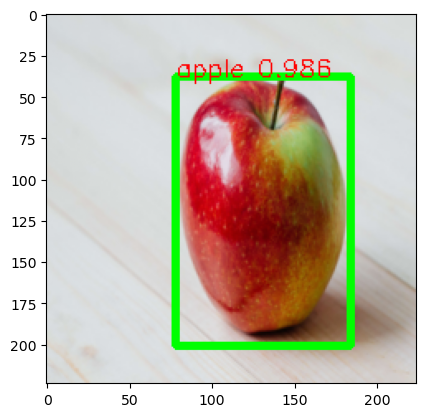

In [ ]:
# The fisrt image (Apple)
img = Image.open("/kaggle/input/apples/apple.jpg").convert("RGB")
img_numpy = np.array(img.resize((224, 224), resample=Image.Resampling.BILINEAR)) / 255.
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1) # converting np_array, H,W,C -> torch_tensor, C,H,W
img = img[None, :]

model.eval()
img = img.to(device)
prediction = model(img)

decode_print(img_numpy, prediction)

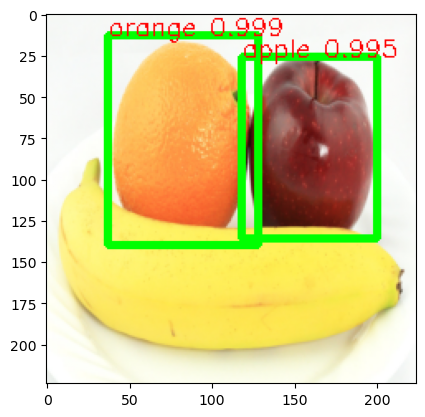

In [ ]:
# The second image (Apple, Orange, Banana)
img = Image.open("/kaggle/input/fruits/mixed.jpg").convert("RGB")
img_numpy = np.array(img.resize((224, 224), resample=Image.Resampling.BILINEAR)) / 255.
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1) # converting np_array, H,W,C -> torch_tensor, C,H,W
img = img[None, :]

model.eval()
img = img.to(device)
prediction = model(img)

decode_print(img_numpy, prediction)

**2.1) My second model for exploration is pretrained SSD**

In [ ]:
model2 = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model2.eval()

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 97.8MB/s] 


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

**Let's check the inference of our model**

In [ ]:
# Let's check inference this model on the same image of person and we can see that predictions are the same
img = Image.open("/kaggle/input/person/person.jpg").convert("RGB")
img_np = np.array(img.resize((224, 224), resample=Image.Resampling.BILINEAR)) / 255.
img = torch.from_numpy(img_np.astype('float32')).permute(2,0,1)
img = img[None, :]

prediction = model2(img)
prediction

[{'boxes': tensor([[7.5458e+01, 4.8332e+00, 1.7592e+02, 2.2400e+02],
          [1.1142e+02, 8.1454e+01, 1.2235e+02, 1.4496e+02],
          [1.4365e+02, 1.7597e+02, 1.8222e+02, 2.2296e+02],
          [1.3741e+02, 1.1385e+02, 1.7780e+02, 2.2400e+02],
          [1.6764e+02, 8.3958e+01, 2.0263e+02, 1.1423e+02],
          [8.2195e+01, 1.4133e+02, 9.8027e+01, 1.8520e+02],
          [8.0188e+01, 1.5644e+02, 1.8475e+02, 2.2400e+02],
          [7.2648e+01, 1.6340e+02, 1.0952e+02, 2.2400e+02],
          [1.5842e+02, 8.1209e+01, 2.2400e+02, 1.9846e+02],
          [1.8764e+02, 8.4914e+01, 2.1848e+02, 1.1558e+02],
          [1.1138e+02, 1.0089e+02, 1.5604e+02, 2.2108e+02],
          [1.8296e+02, 7.1728e+01, 2.0645e+02, 1.1406e+02],
          [1.1674e+02, 8.7630e+01, 1.2721e+02, 1.2309e+02],
          [1.7275e+02, 9.4614e+01, 1.8959e+02, 1.1357e+02],
          [1.5054e+02, 1.4263e+02, 1.7246e+02, 2.1937e+02],
          [1.3319e+02, 3.6929e+00, 1.6928e+02, 7.6802e+01],
          [1.1821e+02, 1.0067e+

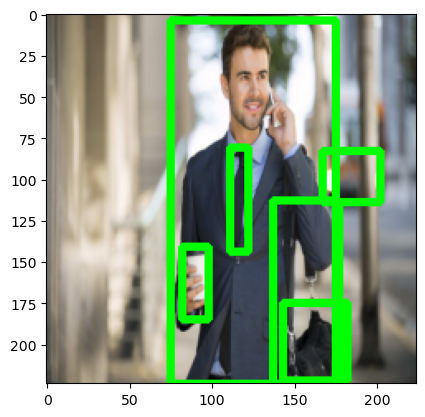

In [ ]:
plot_image(img_np, prediction)

**Compability check of our dataloader with the model below + fine-tuning the model with reinitialization classification head**

In [ ]:
num_classes = 4
anchors = model2.anchor_generator.num_anchors_per_location()
out_channels = [512, 1024, 512, 256, 256, 256]

model2.head.classification_head = SSDClassificationHead(out_channels, anchors, num_classes)

In [ ]:
model2.train()
device = torch.device("cuda:0")
model2 = model2.to(device)

batch = next(iter(train_dataloader))
images, targets = batch

images = [image.to(device) for image in images]
targets = [{labels: boxes.to(device) for labels, boxes in target.items()} for target in targets]

predictions = model2(images, targets) # And we can see that it compiled without any error !
predictions

{'bbox_regression': tensor(0.8549, device='cuda:0', grad_fn=<DivBackward0>),
 'classification': tensor(21.1578, device='cuda:0', grad_fn=<DivBackward0>)}

**2.2) The second step is to train our model**

In [ ]:
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, weight_decay=5e-4, momentum=0.9)
n_epochs = 15

l_t_history = []
l_v_history = []
mAP_history = []
best_mAP_SSD = 0
for epoch in range(n_epochs):
    loss_train_history = 0
    loss_train_regression = 0
    loss_train_classification = 0

    model2.train()
    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}") as pbar:
        for i, data in enumerate(pbar):
            images, targets = data
            images = [image.to(device) for image in images]
            targets = [{labels: boxes.to(device) for labels, boxes in target.items()} for target in targets]

            optimizer.zero_grad()
            losses = model2(images, targets)
            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()

            loss_train_history += loss.cpu().item()
            train_regression, train_classification = [loss.cpu().item() for loss in losses.values()]
            loss_train_regression += train_regression
            loss_train_classification += train_classification

        l_t_history.append(loss_train_history)
        print(f"United training loss: {loss_train_history / len(train_dataloader)}")
        print(f"Classifier training loss: {loss_train_classification / len(train_dataloader)}")
        print(f"Box regression training loss: {loss_train_regression / len(train_dataloader)}")



    loss_val_history = 0
    loss_val_classification = 0
    loss_val_regression = 0
    with tqdm(val_dataloader, desc=f"Epoch {epoch+1}") as pbar:
        with torch.no_grad():
            for i, data in enumerate(pbar):
                images, targets = data
                images = [image.to(device) for image in images]
                targets = [{labels: boxes.to(device) for labels, boxes in target.items()} for target in targets]

                optimizer.zero_grad()
                losses = model2(images, targets)
                loss = sum(loss for loss in losses.values())

                loss_val_history += loss.cpu().item()
                val_regression, val_classification = [loss.cpu().item() for loss in losses.values()]
                loss_val_classification += val_classification
                loss_val_regression += val_regression
            l_v_history.append(loss_val_history)
            print(f"United val loss: {loss_val_history / len(val_dataloader)}")
            print(f"Classifier val loss: {loss_val_classification / len(val_dataloader)}")
            print(f"Box regression val loss: {loss_val_regression / len(val_dataloader)}")


    map_per_batch = []

    model2.eval()
    with tqdm(val_dataloader, desc=f"Epoch {epoch+1}") as pbar:
        with torch.no_grad():
            for i, data in enumerate(pbar):
                images, targets = data
                images = [image.to(device) for image in images]

                optimizer.zero_grad()
                predictions = model2(images)
                map_this_batch = mAP(predictions, targets)
                if map_this_batch > best_mAP_SSD:
                    best_mAP_SSD = map_this_batch
                map_per_batch.append(map_this_batch)

    mAP_history.append(sum(map_per_batch) / len(map_per_batch))
    print(f"mAP on this epoch is: {sum(map_per_batch) / len(map_per_batch)}")
    print("Saving weights...")
    torch.save(model2.state_dict(), 'model2.pth') # Save our trained weights

Epoch 1: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


United training loss: 0.4953488399585088
Classifier training loss: 0.3311416601141294
Box regression training loss: 0.16420717760920525


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


United val loss: 2.6166092327662875
Classifier val loss: 1.9586338145392281
Box regression val loss: 0.6579754395144326


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


mAP on this epoch is: 0.5953553318977356
Saving weights...


Epoch 2: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


United training loss: 0.48217025498549143
Classifier training loss: 0.3120586762825648
Box regression training loss: 0.1701115811864535


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


United val loss: 2.612342255456107
Classifier val loss: 1.9366627420697893
Box regression val loss: 0.6756795176437923


Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


mAP on this epoch is: 0.5991164445877075
Saving weights...


Epoch 3: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


United training loss: 0.4380973011255264
Classifier training loss: 0.2691882054011027
Box regression training loss: 0.16890909696618717


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


United val loss: 2.731697508266994
Classifier val loss: 2.008951851299831
Box regression val loss: 0.7227456867694855


Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


mAP on this epoch is: 0.5970364212989807
Saving weights...


Epoch 4: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


United training loss: 0.4125960956017176
Classifier training loss: 0.24397345582644145
Box regression training loss: 0.16862263828516005


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


United val loss: 3.01517983845302
Classifier val loss: 2.105525715010507
Box regression val loss: 0.9096541149275643


Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


mAP on this epoch is: 0.5414680242538452
Saving weights...


Epoch 5: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


United training loss: 0.4517926702896754
Classifier training loss: 0.24255139380693436
Box regression training loss: 0.2092412774761518


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


United val loss: 3.0690979106085643
Classifier val loss: 2.1579485620771135
Box regression val loss: 0.9111493527889252


Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


mAP on this epoch is: 0.5521860718727112
Saving weights...


Epoch 6: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s]


United training loss: 0.44529588719209034
Classifier training loss: 0.2494803418715795
Box regression training loss: 0.19581554780403773


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


United val loss: 2.8026039940970287
Classifier val loss: 2.0844272715704784
Box regression val loss: 0.7181767310414996


Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


mAP on this epoch is: 0.6175031661987305
Saving weights...


Epoch 7: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


United training loss: 0.38145049462715785
Classifier training loss: 0.20587200572093328
Box regression training loss: 0.17557849138975143


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


United val loss: 2.8348312377929688
Classifier val loss: 2.1256516320364818
Box regression val loss: 0.7091795461518424


Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


mAP on this epoch is: 0.6102968454360962
Saving weights...


Epoch 8: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


United training loss: 0.4069369713465373
Classifier training loss: 0.19969322582085927
Box regression training loss: 0.20724374502897264


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


United val loss: 2.7233380930764333
Classifier val loss: 2.0190692799431935
Box regression val loss: 0.7042687833309174


Epoch 8: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


mAP on this epoch is: 0.598774254322052
Saving weights...


Epoch 9: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


United training loss: 0.33358487784862517
Classifier training loss: 0.1729212611913681
Box regression training loss: 0.16066361541549365


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


United val loss: 2.7242026158741544
Classifier val loss: 2.0502791149275645
Box regression val loss: 0.6739234562431063


Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


mAP on this epoch is: 0.6194879412651062
Saving weights...


Epoch 10: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


United training loss: 0.28590348611275357
Classifier training loss: 0.14334220613042514
Box regression training loss: 0.14256127923727036


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


United val loss: 2.9200353963034495
Classifier val loss: 2.169188141822815
Box regression val loss: 0.7508472544806344


Epoch 10: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


mAP on this epoch is: 0.5688589811325073
Saving weights...


Epoch 11: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


United training loss: 0.24668605277935665
Classifier training loss: 0.12492464284102121
Box regression training loss: 0.12176140795151393


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


United val loss: 2.8435680185045515
Classifier val loss: 2.1714279566492354
Box regression val loss: 0.6721399979931968


Epoch 11: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


mAP on this epoch is: 0.5971683859825134
Saving weights...


Epoch 12: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


United training loss: 0.2335119848450025
Classifier training loss: 0.11600891426205635
Box regression training loss: 0.11750307033459345


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


United val loss: 3.1481344359261647
Classifier val loss: 2.4053653478622437
Box regression val loss: 0.742769113608769


Epoch 12: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


mAP on this epoch is: 0.5715470910072327
Saving weights...


Epoch 13: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


United training loss: 0.22297760397195815
Classifier training loss: 0.10610511278112729
Box regression training loss: 0.11687249268094699


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


United val loss: 2.8387531893593922
Classifier val loss: 2.1260363715035573
Box regression val loss: 0.7127167965684619


Epoch 13: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


mAP on this epoch is: 0.594795823097229
Saving weights...


Epoch 14: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


United training loss: 0.2307228699326515
Classifier training loss: 0.10370784302552541
Box regression training loss: 0.12701502442359924


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


United val loss: 2.783549955912999
Classifier val loss: 2.065354219504765
Box regression val loss: 0.7181957066059113


Epoch 14: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


mAP on this epoch is: 0.5298020243644714
Saving weights...


Epoch 15: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


United training loss: 0.23829384197791417
Classifier training loss: 0.10348686302701632
Box regression training loss: 0.13480697597066563


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


United val loss: 2.9455192429678783
Classifier val loss: 2.2438078267233714
Box regression val loss: 0.7017113736697606


Epoch 15: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


mAP on this epoch is: 0.5601533055305481
Saving weights...


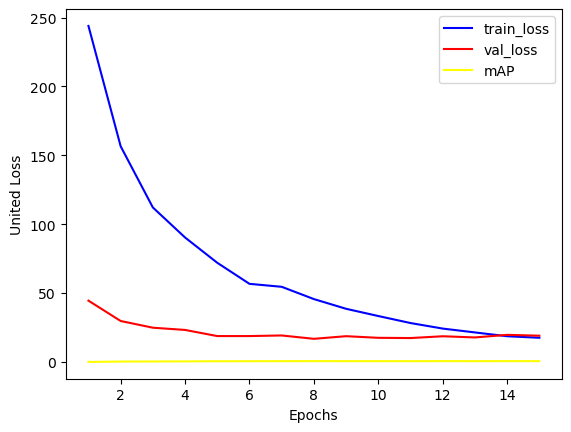

In [ ]:
# Plotting results
x = [i+1 for i in range(n_epochs)]
y1 = l_t_history
y2 = l_v_history
y3 = mAP_history

fig, ax = plt.subplots()
ax.plot(x, y1, color='blue', label='train_loss')
ax.plot(x, y2, color='red', label='val_loss')
ax.plot(x, y3, color='yellow', label='mAP')

ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('United Loss')

plt.show()

**We need to look on inference now**

0.998891294002533


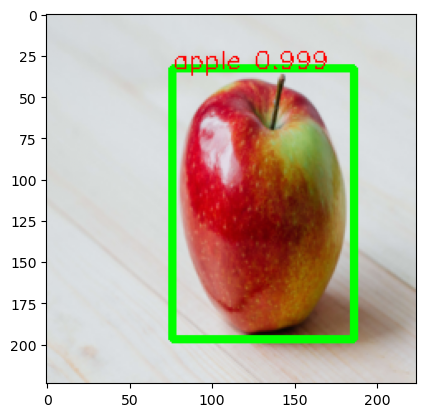

In [ ]:
# The fisrt image (Apple)
img = Image.open("/kaggle/input/apples/apple.jpg").convert("RGB")
img_numpy = np.array(img.resize((224, 224), resample=Image.Resampling.BILINEAR)) / 255.
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1) # converting np_array, H,W,C -> torch_tensor, C,H,W
img = img[None, :]

model.eval()
img = img.to(device)
prediction = model2(img)

decode_print(img_numpy, prediction)

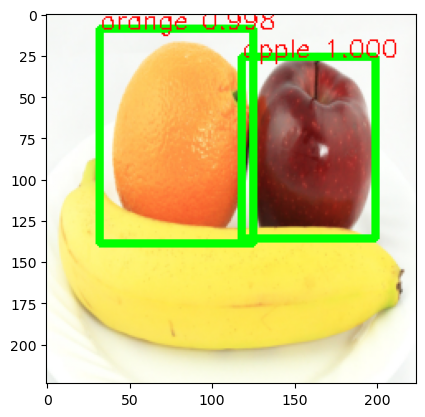

In [ ]:
# The second image (Apple, Orange, Banana)
img = Image.open("/kaggle/input/fruits/mixed.jpg").convert("RGB")
img_numpy = np.array(img.resize((224, 224), resample=Image.Resampling.BILINEAR)) / 255.
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1) # converting np_array, H,W,C -> torch_tensor, C,H,W
img = img[None, :]

model.eval()
img = img.to(device)
prediction = model2(img)

decode_print(img_numpy, prediction)

**3) In comparison we can ivestigate that Faster R-CNN model perform as well as SSD model !**

In [ ]:
best_mAP_frcnn.item()

0.7345550060272217

In [ ]:
best_mAP_SSD.item()

0.7338581085205078

**4) Fruit detection may be useful in various cases:
The neural network can be used in production lines for automatic sorting and classification of fruits by their type. This will help to improve the efficiency and accuracy of the fruit sorting and packaging process.**

**The neural network can be used in stores and supermarkets to automatically identify and inventory fruits on the shelves. This will help simplify the process of accounting for goods, inventory control and theft prevention.**

**The neural network can be used in scientific research to study the behavior and characteristics of various types of fruits. It can help in the analysis and classification of fruit data, as well as in the development of new methods of fruit processing and storage.**